# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [35]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import gaussian_filter, wiener_filter, laplacian_filter, gaussian_weighted_substract_filter, mean_filter, median_filter, conservative_filter, low_pass_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

ImportError: cannot import name 'low_pass_filter' from 'debruiteur.noise.filters' (C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\noise\filters.py)

In [43]:
import debruiteur
dir(debruiteur.noise.filters)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'conservative_filter',
 'convolve2d',
 'cv2',
 'fft_filter',
 'gaussian_filter',
 'gaussian_weighted_substract_filter',
 'img_as_float',
 'laplacian_filter',
 'mean_filter',
 'median_filter',
 'np',
 'unsupervised_wiener',
 'wiener',
 'wiener_filter']

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


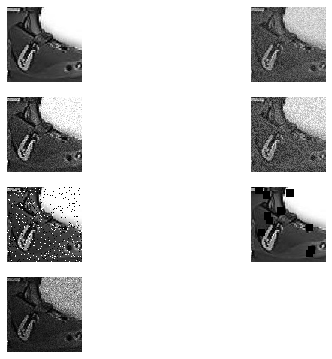

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,401.353997,0.147535,22.095528,0.429462
1,PoissonNoise,234.339400,0.112734,24.432350,0.508205
2,UniformNoise,3378.778068,0.428066,12.843207,0.301594
3,SaltPepperNoise,2280.215500,0.351657,14.551045,0.279189
4,SquareMaskNoise,1117.390100,0.246169,17.648755,0.829580
5,SpeckleNoise,743.052234,0.200743,19.420610,0.506061


In [4]:
metrics_example(df_noised, noise_class_list)

You can see the score for each type of noise for each metric. We can notice that the type of noise that deteriorates the image the most is SpeckleNoise. We can also see that the Gaussian, Poisson noise is one of the filters that deteriorates the image the least. 

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods
After the output of the neural networks we apply a filter to smooth the image. Indeed, the images at the output of the neural network are a little blurred. These filters allow to reduce the blur. The filters used are : 
* Wiener filter
* Laplacian filter
* Gaussian Weigthed filter

In [7]:

noise_reduction_methods = [('Gaussian Filter', lambda img: gaussian_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('Low pass FFT Filter', lambda img: low_pass_filter(img * 255)),
                           
                           ('Convolutional Autoencoder None', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Convolutional Autoencoder Wiener', lambda x : wiener_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Laplacian', lambda x : laplacian_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Gaussian Weighted', lambda x : gaussian_weighted_substract_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),

                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),

                           ('Generative Adversarial Network None', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Generative Adversarial Network Wiener', lambda x : wiener_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Laplacian', lambda x : laplacian_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Weighted', lambda x : gaussian_weighted_substract_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255))]

### Noise reduction methods metrics averaged on all kind of noises

In [8]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,MSE,NRMSE,PSNR,SSIM
Gaussian Filter,1394.388017,0.265936,18.124644,0.534886
Mean Filter,1568.001264,0.293329,16.929086,0.385979
Median Filter,1401.306170,0.277726,17.447573,0.434636
Conservative Filter,2203.133580,0.271782,19.620558,0.675473
Low pass FFT Filter,1486.392567,0.257526,18.833157,0.592799
Convolutional Autoencoder None,3944.894861,0.465774,12.926411,0.166335
Convolutional Autoencoder Wiener,4373.297371,0.503297,11.978385,0.135931
Convolutional Autoencoder Laplacian,3968.056839,0.467745,12.876844,0.156575
Convolutional Autoencoder Gaussian Weighted,3996.513567,0.468952,12.857424,0.168008
Dense Autoencoder,5626.560480,0.576329,10.710400,0.008374


### Noise reductions methods for each noise type
#### Structural similarity (SSIM)

A high SSIM is desired

In [9]:
df_stat_ssim = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")
df_stat_ssim

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.479047,0.595429,0.468424,0.459427,0.570052,0.422961
Mean Filter,0.331405,0.429795,0.332173,0.353268,0.393892,0.292314
Median Filter,0.352925,0.458280,0.335983,0.526586,0.438325,0.307323
Conservative Filter,0.622805,0.709924,0.543667,0.515243,0.829896,0.594387
Low pass FFT Filter,0.578781,0.667034,0.542709,0.464112,0.644245,0.529748
Convolutional Autoencoder None,0.168274,0.172027,0.168685,0.137564,0.146602,0.051053
Convolutional Autoencoder Wiener,0.156265,0.142150,0.152931,0.119066,0.118459,0.087856
Convolutional Autoencoder Laplacian,0.155301,0.160945,0.153504,0.126476,0.138717,0.048256
Convolutional Autoencoder Gaussian Weighted,0.182803,0.175627,0.178929,0.135929,0.145303,0.053104
Dense Autoencoder,0.007624,0.008652,0.007890,0.008531,0.008693,0.007595


In [10]:
df_stat_ssim.mean(axis=1).sort_values()

Dense Autoencoder                              0.008164
Convolutional Autoencoder Wiener               0.129454
Convolutional Autoencoder Laplacian            0.130533
Convolutional Autoencoder None                 0.140701
Convolutional Autoencoder Gaussian Weighted    0.145283
Generative Adversarial Network Laplacian       0.164574
Generative Adversarial Network Wiener          0.319564
Mean Filter                                    0.355474
Median Filter                                  0.403237
Generative Adversarial Network None            0.452003
Generative Adversarial Network Weighted        0.487720
Gaussian Filter                                0.499223
Low pass FFT Filter                            0.571105
Conservative Filter                            0.635987
dtype: float64

#### Peak signal-to-noise ratio (PSNR)

A High PSNR is desired but not in all cases. It is often used as a reconstruction loss when compressing images.

In [11]:
df_stat_psnr = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")
df_stat_psnr

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,17.938438,21.489597,18.286964,19.363997,15.959693,13.305919
Mean Filter,16.744590,19.318953,17.167285,18.483377,15.585724,12.992670
Median Filter,17.349160,20.066534,17.475607,20.109591,14.982969,12.972237
Conservative Filter,19.257642,24.168920,18.623485,15.864033,16.114021,13.626858
Low pass FFT Filter,18.597934,22.650272,18.799620,17.845233,16.048742,13.649366
Convolutional Autoencoder None,13.252716,13.358536,13.358687,12.095496,12.250419,8.802010
Convolutional Autoencoder Wiener,12.958863,12.277447,12.951960,11.481986,11.282991,10.827295
Convolutional Autoencoder Laplacian,13.177166,13.266748,13.257044,12.109734,12.259854,8.788550
Convolutional Autoencoder Gaussian Weighted,13.428211,13.356710,13.418515,12.100424,11.485319,8.827523
Dense Autoencoder,10.752437,10.719825,10.756347,10.727063,10.724624,10.672752


In [12]:
df_stat_psnr.mean(axis=1).sort_values()

Dense Autoencoder                              10.725508
Convolutional Autoencoder Wiener               11.963424
Convolutional Autoencoder Gaussian Weighted    12.102784
Convolutional Autoencoder Laplacian            12.143183
Convolutional Autoencoder None                 12.186311
Generative Adversarial Network Laplacian       12.588789
Generative Adversarial Network None            13.337663
Generative Adversarial Network Weighted        13.372455
Generative Adversarial Network Wiener          13.753479
Mean Filter                                    16.715433
Median Filter                                  17.159350
Gaussian Filter                                17.724101
Low pass FFT Filter                            17.931861
Conservative Filter                            17.942493
dtype: float64

#### Mean squared error (MSE)

A low MSE is desired.

In [13]:
df_stat_mse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")
df_stat_mse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,1112.996615,494.181429,998.486462,784.249627,1833.998116,3212.363226
Mean Filter,1417.985627,803.406711,1282.952491,956.144725,1802.365781,3340.370246
Median Filter,1234.091582,695.760839,1190.278216,690.177616,2168.770715,3388.169105
Conservative Filter,794.651289,253.317636,897.326072,1712.918649,1713.116085,2801.080255
Low pass FFT Filter,931.514145,367.581722,873.077296,1068.260770,1402.350682,2890.360006
Convolutional Autoencoder None,3003.830310,3048.110856,3010.436946,4047.233234,4070.276244,8548.151482
Convolutional Autoencoder Wiener,3412.123911,3917.345869,3296.694868,4643.249878,5020.872814,5619.867860
Convolutional Autoencoder Laplacian,3079.696293,3104.786022,3129.625522,4065.310244,4086.894003,8906.463546
Convolutional Autoencoder Gaussian Weighted,3133.285007,3046.135706,3001.666845,4094.451932,4347.440628,8580.388404
Dense Autoencoder,5572.125674,5616.508525,5569.880194,5603.017878,5601.925066,5679.641270


In [14]:
df_stat_mse.mean(axis=1).sort_values()

Low pass FFT Filter                            1255.524104
Conservative Filter                            1362.068331
Gaussian Filter                                1406.045912
Median Filter                                  1561.208012
Mean Filter                                    1600.537597
Generative Adversarial Network Wiener          2932.728130
Generative Adversarial Network None            3338.577481
Generative Adversarial Network Weighted        3368.520586
Generative Adversarial Network Laplacian       3916.500066
Convolutional Autoencoder None                 4288.006512
Convolutional Autoencoder Wiener               4318.359200
Convolutional Autoencoder Gaussian Weighted    4367.228087
Convolutional Autoencoder Laplacian            4395.462605
Dense Autoencoder                              5607.183101
dtype: float64

#### Root mean squared error (RMSE)

A low RMSE is desired.

In [15]:
df_stat_rmse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")
df_stat_rmse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.256952,0.169730,0.243079,0.216265,0.315331,0.427488
Mean Filter,0.289703,0.217484,0.275747,0.237255,0.333697,0.449789
Median Filter,0.275299,0.201120,0.264612,0.200529,0.356256,0.443238
Conservative Filter,0.221043,0.121591,0.230570,0.319673,0.312474,0.407249
Low pass FFT Filter,0.234658,0.146943,0.227717,0.254049,0.291971,0.415401
Convolutional Autoencoder None,0.421622,0.425125,0.421948,0.490658,0.491036,0.717220
Convolutional Autoencoder Wiener,0.447155,0.481424,0.447013,0.521205,0.551540,0.573812
Convolutional Autoencoder Laplacian,0.427921,0.429534,0.428613,0.490553,0.490656,0.721857
Convolutional Autoencoder Gaussian Weighted,0.420722,0.425794,0.420476,0.493603,0.495601,0.711175
Dense Autoencoder,0.573540,0.575705,0.573383,0.575121,0.577307,0.578696


In [16]:
df_stat_rmse.mean(axis=1).sort_values()

Low pass FFT Filter                            0.261790
Conservative Filter                            0.268766
Gaussian Filter                                0.271474
Median Filter                                  0.290175
Mean Filter                                    0.300612
Generative Adversarial Network Wiener          0.409248
Generative Adversarial Network None            0.432467
Generative Adversarial Network Weighted        0.433567
Generative Adversarial Network Laplacian       0.473048
Convolutional Autoencoder Gaussian Weighted    0.494562
Convolutional Autoencoder None                 0.494601
Convolutional Autoencoder Laplacian            0.498189
Convolutional Autoencoder Wiener               0.503691
Dense Autoencoder                              0.575625
dtype: float64

# Conclusion

As we can observe the conservative filter has the best score on all most all type of noises.  
It may be because the changes in the images are very small so it the denoised image is similar to the original image.  
This is particularly true when the images are not very noised and the performance would be different if the images had more noise.  

The generative adversial neural network reduces the noise quite well, but as the image is generated, the colors are sometimes different which is not the case of other filters.  
When we sum all these small differences pixelwise it is expected to have a high error.  
Even though the results are visually good.  

For each filter the metrics where computed on all kind of noises.  
Usually we should use a specific filter on a particular noise as they perform better on the approriate noise.  

Comparing the neural networks, the generative adversial neural network has the best performances.  
If we had a GPU with more RAM, we could increase the depth of the GAN by putting more convolutional blocks.  
This is also the reason why we reduced the image's size to 100x100 and used grayscale.  
An other improvement would be to implement the style loss in order to keep better texture details and so improve the performance.  

Another point to note is that the structural similarity has been criticized for not being more corelated to the human's perception as the mean squarred error.  
Comparing the images visually is sometimes more valuable than comparing metrics.  

This conclusion shouldn't be used to say that classical filters (gaussian etc) perform always better than neural networks in all cases.  